In [443]:
# Run opencritic_api__games.ipynb first.
import pandas as pd
import json
import ast
import numpy as np
import math
import missingno as msno
from datetime import datetime

In [444]:
raw_reviews_df = pd.read_csv('/Users/connor.stevens/Library/Mobile Documents/com~apple~CloudDocs/Masters Thesis Spring 2023/data/final_df (1).csv')
raw_reviews_df.head()

,Unnamed: 0,igdb_name,opencritic_name,opencritic_id,igdb_id,dist,first_release_date,involved_companies,game_modes,genres,...,topCriticScore,tier,percentile,num_platforms,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate,tenthReviewDate,criticalReviewDate
0,0,The Last Guardian,The Last Guardian,1524,117,0.0,1480982400,"[{'id': 36389, 'company': {'id': 44, 'name': '...","[{'id': 1, 'name': 'Single player'}]","[{'id': 8, 'name': 'Platform'}, {'id': 9, 'nam...",...,80.528736,Strong,83.0,NaN,2016-12-05T15:03:00.000Z,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,2016-12-05T05:00:00.000Z,2016-12-05T05:00:00.000Z
1,1,Final Fantasy XV,Final Fantasy XV,1512,359,0.0,1480377600,"[{'id': 53470, 'company': {'id': 2670, 'name':...","[{'id': 1, 'name': 'Single player'}, {'id': 3,...","[{'id': 12, 'name': 'Role-playing (RPG)'}, {'i...",...,80.736842,Strong,83.0,NaN,2016-11-28T15:03:00.000Z,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,2016-11-28T05:00:00.000Z,2016-11-28T05:00:00.000Z
2,2,Prison Architect,Prison Architect,1942,1338,0.0,1444089600,"[{'id': 201720, 'company': {'id': 1224, 'name'...","[{'id': 1, 'name': 'Single player'}, {'id': 2,...","[{'id': 13, 'name': 'Simulator'}, {'id': 15, '...",...,79.893617,Strong,76.0,NaN,NaN,2015-10-06T00:00:00.000Z,2015-10-05T04:00:00.000Z,2018-10-29T04:00:00.000Z,2015-10-07T04:00:00.000Z,2015-10-19T04:00:00.000Z
3,3,Mirror's Edge Catalyst,Mirror's Edge Catalyst,1549,2112,0.0,1465257600,"[{'id': 7372, 'company': {'id': 1, 'name': 'El...","[{'id': 1, 'name': 'Single player'}, {'id': 2,...","[{'id': 4, 'name': 'Fighting'}, {'id': 31, 'na...",...,70.168831,Fair,44.0,NaN,2016-06-06T16:03:00.000Z,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z,2016-06-06T04:00:00.000Z,2016-06-06T04:00:00.000Z
4,4,Star Wars Battlefront,Star Wars Battlefront,1511,2113,0.0,1447718400,"[{'id': 56415, 'company': {'id': 1, 'name': 'E...","[{'id': 1, 'name': 'Single player'}, {'id': 2,...","[{'id': 5, 'name': 'Shooter'}]",...,71.183908,Fair,48.0,NaN,2015-11-17T05:05:00.000Z,2015-11-17T00:00:00.000Z,2015-11-08T05:00:00.000Z,2017-02-13T05:00:00.000Z,2015-11-16T05:00:00.000Z,2015-11-17T05:00:00.000Z


<Axes: >

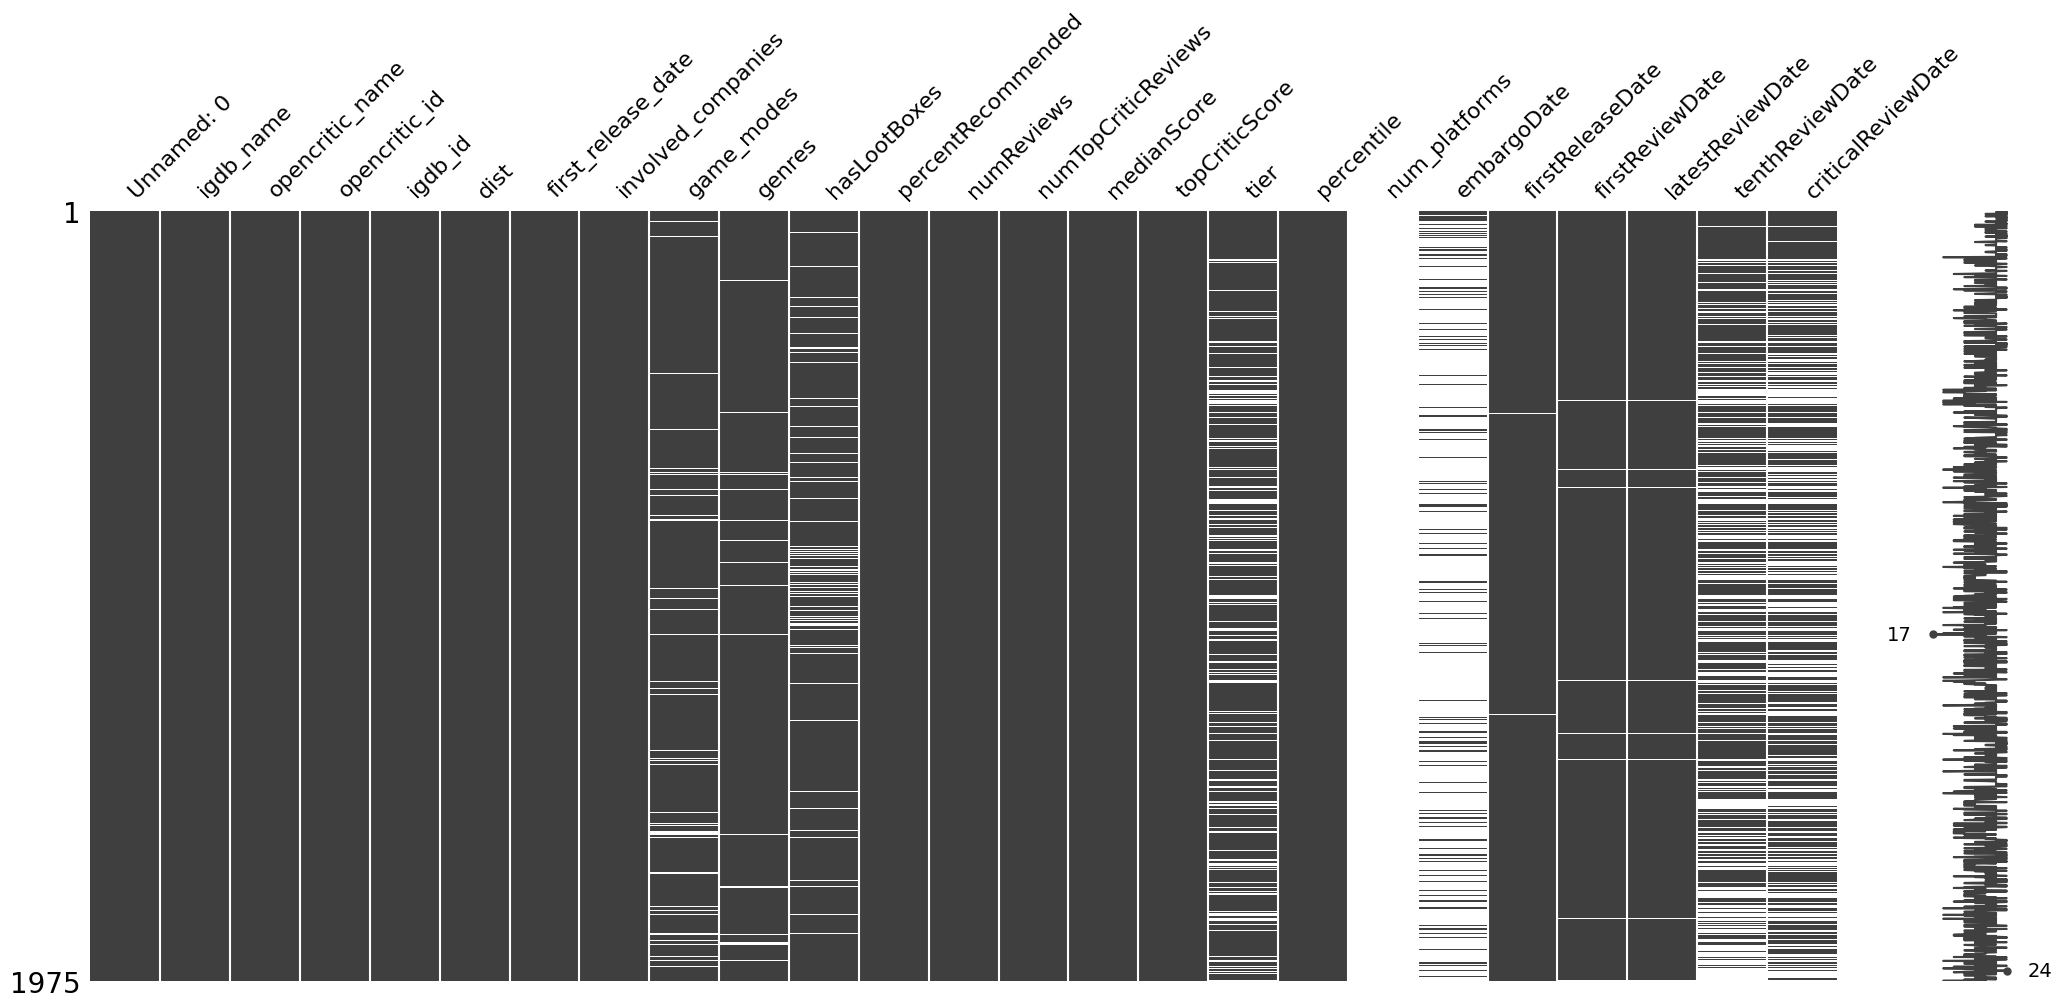

In [445]:
# Check how much missing data is present in the reviews dataset.
%matplotlib inline

msno.matrix(raw_reviews_df)

Thanks to the data obtained from IGDB, involved_companies, game_modes and genres are not needed and can be dropped. Of the OpenCritic-specific data; tier, num_platforms, embargoDate, tenthReviewDate and criticalReviewDate have too many missing values to include. hasLootBoxes, firstReleaseDate, firstReviewDate and latestReviewDate have some missing values but will be included with missing values handled later.

In [446]:
# Drop columns.
columns_to_drop = ['involved_companies', 'game_modes', 'genres', 'tier', 'num_platforms', 'tenthReviewDate', 'criticalReviewDate']
raw_reviews_df = raw_reviews_df.drop(columns_to_drop, axis=1)
raw_reviews_df.head()

,Unnamed: 0,igdb_name,opencritic_name,opencritic_id,igdb_id,dist,first_release_date,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate
0,0,The Last Guardian,The Last Guardian,1524,117,0.0,1480982400,False,70.491803,128.0,96.0,85.0,80.528736,83.0,2016-12-05T15:03:00.000Z,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z
1,1,Final Fantasy XV,Final Fantasy XV,1512,359,0.0,1480377600,False,74.305556,148.0,95.0,85.0,80.736842,83.0,2016-11-28T15:03:00.000Z,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z
2,2,Prison Architect,Prison Architect,1942,1338,0.0,1444089600,False,81.355932,61.0,47.0,80.0,79.893617,76.0,NaN,2015-10-06T00:00:00.000Z,2015-10-05T04:00:00.000Z,2018-10-29T04:00:00.000Z
3,3,Mirror's Edge Catalyst,Mirror's Edge Catalyst,1549,2112,0.0,1465257600,False,29.166667,103.0,77.0,70.0,70.168831,44.0,2016-06-06T16:03:00.000Z,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z
4,4,Star Wars Battlefront,Star Wars Battlefront,1511,2113,0.0,1447718400,False,33.009709,111.0,99.0,70.0,71.183908,48.0,2015-11-17T05:05:00.000Z,2015-11-17T00:00:00.000Z,2015-11-08T05:00:00.000Z,2017-02-13T05:00:00.000Z


In [447]:
raw_reviews_df[raw_reviews_df['dist'] == 0]

,Unnamed: 0,igdb_name,opencritic_name,opencritic_id,igdb_id,dist,first_release_date,hasLootBoxes,percentRecommended,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate
0,0,The Last Guardian,The Last Guardian,1524,117,0.0,1480982400,False,70.491803,128.0,96.0,85.0,80.528736,83.0,2016-12-05T15:03:00.000Z,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z
1,1,Final Fantasy XV,Final Fantasy XV,1512,359,0.0,1480377600,False,74.305556,148.0,95.0,85.0,80.736842,83.0,2016-11-28T15:03:00.000Z,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z
2,2,Prison Architect,Prison Architect,1942,1338,0.0,1444089600,False,81.355932,61.0,47.0,80.0,79.893617,76.0,NaN,2015-10-06T00:00:00.000Z,2015-10-05T04:00:00.000Z,2018-10-29T04:00:00.000Z
3,3,Mirror's Edge Catalyst,Mirror's Edge Catalyst,1549,2112,0.0,1465257600,False,29.166667,103.0,77.0,70.0,70.168831,44.0,2016-06-06T16:03:00.000Z,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z
4,4,Star Wars Battlefront,Star Wars Battlefront,1511,2113,0.0,1447718400,False,33.009709,111.0,99.0,70.0,71.183908,48.0,2015-11-17T05:05:00.000Z,2015-11-17T00:00:00.000Z,2015-11-08T05:00:00.000Z,2017-02-13T05:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1938,1938,Age of Wonders 4,Age of Wonders 4,14350,232571,0.0,1682985600,False,95.833333,27.0,23.0,83.0,82.222222,89.0,NaN,2023-05-02T00:00:00.000Z,2023-04-27T00:00:00.000Z,2023-05-15T00:00:00.000Z
1945,1945,WBSC eBaseball: Power Pros,WBSC eBaseball: Power Pros,14279,236674,0.0,1675814400,False,-1.000000,4.0,3.0,-1.0,80.000000,83.0,NaN,2023-02-08T00:00:00.000Z,2023-02-09T00:00:00.000Z,2023-03-29T00:00:00.000Z
1946,1946,Paranormasight: The Seven Mysteries of Honjo,PARANORMASIGHT: The Seven Mysteries of Honjo,14408,236694,0.0,1678233600,False,86.111111,38.0,22.0,88.0,81.421053,86.0,2023-03-08T15:00:15.000Z,2023-03-08T00:00:00.000Z,2023-03-08T00:00:00.000Z,2023-05-11T00:00:00.000Z
1953,1953,AFL 23,AFL 23,14912,240298,0.0,1683158400,False,-1.000000,3.0,3.0,-1.0,63.333333,23.0,NaN,2023-05-03T00:00:00.000Z,2023-05-10T00:00:00.000Z,2023-05-15T00:00:00.000Z


In [448]:
# Import igdb_games_cleaned.csv

igdb_games = pd.read_csv('igdb_games_cleaned.csv')
igdb_games.head()

,Unnamed: 0,id,first_release_date,name,slug,mature,single_player,multiplayer,dev1_stock_id,dev2_stock_id,pub1_stock_id,pub2_stock_id
0,0,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,0
1,1,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,26,0
2,3,2112,1465257600,Mirror's Edge Catalyst,mirrors-edge-catalyst,False,True,False,0,0,1,0
3,5,2212,1459209600,MLB The Show 16,mlb-the-show-16,False,True,False,0,0,13634,0
4,6,2933,1548374400,Kingdom Hearts III,kingdom-hearts-iii,False,True,False,26,0,26,0


In [449]:
# Rename id to igdb_id for joining with raw_reviews_df.
igdb_games = igdb_games.rename(columns={"id": "igdb_id"})
igdb_games.head()

,Unnamed: 0,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,dev1_stock_id,dev2_stock_id,pub1_stock_id,pub2_stock_id
0,0,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,0
1,1,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,26,0
2,3,2112,1465257600,Mirror's Edge Catalyst,mirrors-edge-catalyst,False,True,False,0,0,1,0
3,5,2212,1459209600,MLB The Show 16,mlb-the-show-16,False,True,False,0,0,13634,0
4,6,2933,1548374400,Kingdom Hearts III,kingdom-hearts-iii,False,True,False,26,0,26,0


Now that the reviews and games both have an igdb_id and a unix time release date, the two can be joined.

In [450]:
# Join the reviews to the games dataset.
games_reviews_df = pd.merge(igdb_games, raw_reviews_df, how='left', on=['igdb_id', 'first_release_date'])
games_reviews_df.head()

,Unnamed: 0_x,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,dev1_stock_id,dev2_stock_id,...,percentRecommended,numReviews,numTopCriticReviews,medianScore,topCriticScore,percentile,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate
0,0,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,...,70.491803,128.0,96.0,85.0,80.528736,83.0,2016-12-05T15:03:00.000Z,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z
1,1,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,...,74.305556,148.0,95.0,85.0,80.736842,83.0,2016-11-28T15:03:00.000Z,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z
2,3,2112,1465257600,Mirror's Edge Catalyst,mirrors-edge-catalyst,False,True,False,0,0,...,29.166667,103.0,77.0,70.0,70.168831,44.0,2016-06-06T16:03:00.000Z,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z
3,5,2212,1459209600,MLB The Show 16,mlb-the-show-16,False,True,False,0,0,...,93.103448,31.0,28.0,88.0,85.464286,95.0,NaN,2016-03-29T00:00:00.000Z,2016-03-28T04:00:00.000Z,2016-06-15T04:00:00.000Z
4,6,2933,1548374400,Kingdom Hearts III,kingdom-hearts-iii,False,True,False,26,0,...,84.137931,148.0,105.0,85.0,84.202020,93.0,2018-12-06T13:03:00.000Z,2019-01-29T00:00:00.000Z,2019-01-24T05:00:00.000Z,2022-04-01T00:00:00.000Z


In [451]:
games_reviews_df.columns

Index(['Unnamed: 0_x', 'igdb_id', 'first_release_date', 'name', 'slug',
       'mature', 'single_player', 'multiplayer', 'dev1_stock_id',
       'dev2_stock_id', 'pub1_stock_id', 'pub2_stock_id', 'Unnamed: 0_y',
       'igdb_name', 'opencritic_name', 'opencritic_id', 'dist', 'hasLootBoxes',
       'percentRecommended', 'numReviews', 'numTopCriticReviews',
       'medianScore', 'topCriticScore', 'percentile', 'embargoDate',
       'firstReleaseDate', 'firstReviewDate', 'latestReviewDate'],
      dtype='object')

In [452]:
# Drop unused columns.
games_reviews_df = games_reviews_df.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
games_reviews_df.columns

Index(['igdb_id', 'first_release_date', 'name', 'slug', 'mature',
       'single_player', 'multiplayer', 'dev1_stock_id', 'dev2_stock_id',
       'pub1_stock_id', 'pub2_stock_id', 'igdb_name', 'opencritic_name',
       'opencritic_id', 'dist', 'hasLootBoxes', 'percentRecommended',
       'numReviews', 'numTopCriticReviews', 'medianScore', 'topCriticScore',
       'percentile', 'embargoDate', 'firstReleaseDate', 'firstReviewDate',
       'latestReviewDate'],
      dtype='object')

In [453]:

long_company_ids = pd.melt(games_reviews_df, id_vars='igdb_id', value_vars=['dev1_stock_id', 'dev2_stock_id', 'pub1_stock_id', 'pub2_stock_id'])
long_company_ids = long_company_ids.rename(columns={"value": "igdb_company_id"})
print(long_company_ids['variable'].value_counts())
long_company_ids.head()

variable
dev1_stock_id    982
dev2_stock_id    982
pub1_stock_id    982
pub2_stock_id    982
Name: count, dtype: int64


,igdb_id,variable,igdb_company_id
0,117,dev1_stock_id,0
1,359,dev1_stock_id,26
2,2112,dev1_stock_id,0
3,2212,dev1_stock_id,0
4,2933,dev1_stock_id,26


In [454]:
games_reviews_long_df = pd.merge(games_reviews_df, long_company_ids, how='left', on='igdb_id')
games_reviews_long_df.head()

,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,dev1_stock_id,dev2_stock_id,pub1_stock_id,...,numTopCriticReviews,medianScore,topCriticScore,percentile,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id
0,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,...,96.0,85.0,80.528736,83.0,2016-12-05T15:03:00.000Z,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,dev1_stock_id,0
1,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,...,96.0,85.0,80.528736,83.0,2016-12-05T15:03:00.000Z,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,dev2_stock_id,0
2,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,...,96.0,85.0,80.528736,83.0,2016-12-05T15:03:00.000Z,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100
3,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,...,96.0,85.0,80.528736,83.0,2016-12-05T15:03:00.000Z,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub2_stock_id,0
4,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,26,...,95.0,85.0,80.736842,83.0,2016-11-28T15:03:00.000Z,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,dev1_stock_id,26


In [455]:
games_reviews_long_df.shape

(3928, 28)

Now that the reviews data has been flattened, it is required to get rid of observations where igdb_company_id is 0 as this data is not used.

In [456]:
# First check the types on the columns. Need to check if igdb_company_id is string or int.
games_reviews_long_df.dtypes

igdb_id                  int64
first_release_date       int64
name                    object
slug                    object
mature                    bool
single_player             bool
multiplayer               bool
dev1_stock_id            int64
dev2_stock_id            int64
pub1_stock_id            int64
pub2_stock_id            int64
igdb_name               object
opencritic_name         object
opencritic_id            int64
dist                   float64
hasLootBoxes            object
percentRecommended     float64
numReviews             float64
numTopCriticReviews    float64
medianScore            float64
topCriticScore         float64
percentile             float64
embargoDate             object
firstReleaseDate        object
firstReviewDate         object
latestReviewDate        object
variable                object
igdb_company_id          int64
dtype: object

In [457]:
# Remove observations where the igdb_company_id is 0.

# Get index of rows where igdb_company_id is 0.
zero_index = games_reviews_long_df[games_reviews_long_df['igdb_company_id'] == 0].index
games_reviews_long_df = games_reviews_long_df.drop(zero_index)
games_reviews_long_df.head()

,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,dev1_stock_id,dev2_stock_id,pub1_stock_id,...,numTopCriticReviews,medianScore,topCriticScore,percentile,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id
2,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,...,96.0,85.0,80.528736,83.0,2016-12-05T15:03:00.000Z,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100
4,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,26,...,95.0,85.0,80.736842,83.0,2016-11-28T15:03:00.000Z,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,dev1_stock_id,26
6,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,26,...,95.0,85.0,80.736842,83.0,2016-11-28T15:03:00.000Z,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,pub1_stock_id,26
10,2112,1465257600,Mirror's Edge Catalyst,mirrors-edge-catalyst,False,True,False,0,0,1,...,77.0,70.0,70.168831,44.0,2016-06-06T16:03:00.000Z,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z,pub1_stock_id,1
14,2212,1459209600,MLB The Show 16,mlb-the-show-16,False,True,False,0,0,13634,...,28.0,88.0,85.464286,95.0,NaN,2016-03-29T00:00:00.000Z,2016-03-28T04:00:00.000Z,2016-06-15T04:00:00.000Z,pub1_stock_id,13634


Unnecessary IGDB company ids have been removed, but it is still required to flatten the 'variable' column into `developer` and `publisher` boolean columns as well as add a `stock_id` column to this dataset to enable joining with the financial dataset.

In [458]:
# Write functions for extracting developer or publisher boolean columns.

def is_developer(input_string):
    # If igdb_id was developer id.
    if input_string[0:3] == 'dev':
        return True
    else:
        return False

def is_publisher(input_string):
    # If igdb_id was publisher id.
    if input_string[0:3] == 'pub':
        return True
    else:
        return False

In [459]:
# Create boolean columns.
games_reviews_long_df['developer'] = games_reviews_long_df['variable'].map(is_developer)
games_reviews_long_df['publisher'] = games_reviews_long_df['variable'].map(is_publisher)
games_reviews_long_df.head()

,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,dev1_stock_id,dev2_stock_id,pub1_stock_id,...,topCriticScore,percentile,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher
2,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,...,80.528736,83.0,2016-12-05T15:03:00.000Z,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100,False,True
4,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,26,...,80.736842,83.0,2016-11-28T15:03:00.000Z,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,dev1_stock_id,26,True,False
6,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,26,...,80.736842,83.0,2016-11-28T15:03:00.000Z,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,pub1_stock_id,26,False,True
10,2112,1465257600,Mirror's Edge Catalyst,mirrors-edge-catalyst,False,True,False,0,0,1,...,70.168831,44.0,2016-06-06T16:03:00.000Z,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z,pub1_stock_id,1,False,True
14,2212,1459209600,MLB The Show 16,mlb-the-show-16,False,True,False,0,0,13634,...,85.464286,95.0,NaN,2016-03-29T00:00:00.000Z,2016-03-28T04:00:00.000Z,2016-06-15T04:00:00.000Z,pub1_stock_id,13634,False,True


In [460]:
# Go through all observations and add a stock_id to each game to enable joining with the financial dataset.

# Save companies.json to a variable.
with open('companies.json') as json_file:
  companies_dict = json.load(json_file)

def get_stock_id(igdb_company_id):

  # Loop through each company in companies.json.
  for company in companies_dict:

    if igdb_company_id in company['igdb_ids']:
      return company['stock_id']

    else:
      continue

In [461]:
# use function to get stock_ids.
games_reviews_long_df['stock_id'] = games_reviews_long_df['igdb_company_id'].map(get_stock_id)

games_reviews_long_df.head()

,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,dev1_stock_id,dev2_stock_id,pub1_stock_id,...,percentile,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id
2,117,1480982400,The Last Guardian,the-last-guardian,False,True,False,0,0,10100,...,83.0,2016-12-05T15:03:00.000Z,2016-12-06T00:00:00.000Z,2016-12-05T00:00:00.000Z,2017-09-10T04:00:00.000Z,pub1_stock_id,10100,False,True,JP3435000009
4,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,26,...,83.0,2016-11-28T15:03:00.000Z,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,dev1_stock_id,26,True,False,JP3164630000
6,359,1480377600,Final Fantasy XV,final-fantasy-xv,False,True,False,26,0,26,...,83.0,2016-11-28T15:03:00.000Z,2016-11-29T00:00:00.000Z,2016-08-15T04:00:00.000Z,2018-03-08T05:00:00.000Z,pub1_stock_id,26,False,True,JP3164630000
10,2112,1465257600,Mirror's Edge Catalyst,mirrors-edge-catalyst,False,True,False,0,0,1,...,44.0,2016-06-06T16:03:00.000Z,2016-06-07T00:00:00.000Z,2016-04-26T04:00:00.000Z,2017-08-14T00:00:00.000Z,pub1_stock_id,1,False,True,16721
14,2212,1459209600,MLB The Show 16,mlb-the-show-16,False,True,False,0,0,13634,...,95.0,NaN,2016-03-29T00:00:00.000Z,2016-03-28T04:00:00.000Z,2016-06-15T04:00:00.000Z,pub1_stock_id,13634,False,True,JP3435000009


In [462]:
# Check columns to see what can be dropped.
games_reviews_long_df.columns

Index(['igdb_id', 'first_release_date', 'name', 'slug', 'mature',
       'single_player', 'multiplayer', 'dev1_stock_id', 'dev2_stock_id',
       'pub1_stock_id', 'pub2_stock_id', 'igdb_name', 'opencritic_name',
       'opencritic_id', 'dist', 'hasLootBoxes', 'percentRecommended',
       'numReviews', 'numTopCriticReviews', 'medianScore', 'topCriticScore',
       'percentile', 'embargoDate', 'firstReleaseDate', 'firstReviewDate',
       'latestReviewDate', 'variable', 'igdb_company_id', 'developer',
       'publisher', 'stock_id'],
      dtype='object')

In [463]:
# Drop columns which are no longer needed.
games_reviews_long_df = games_reviews_long_df.drop([
    'dev1_stock_id',
    'dev2_stock_id',
    'pub1_stock_id',
    'pub2_stock_id'
    ]
    , axis=1)

<Axes: >

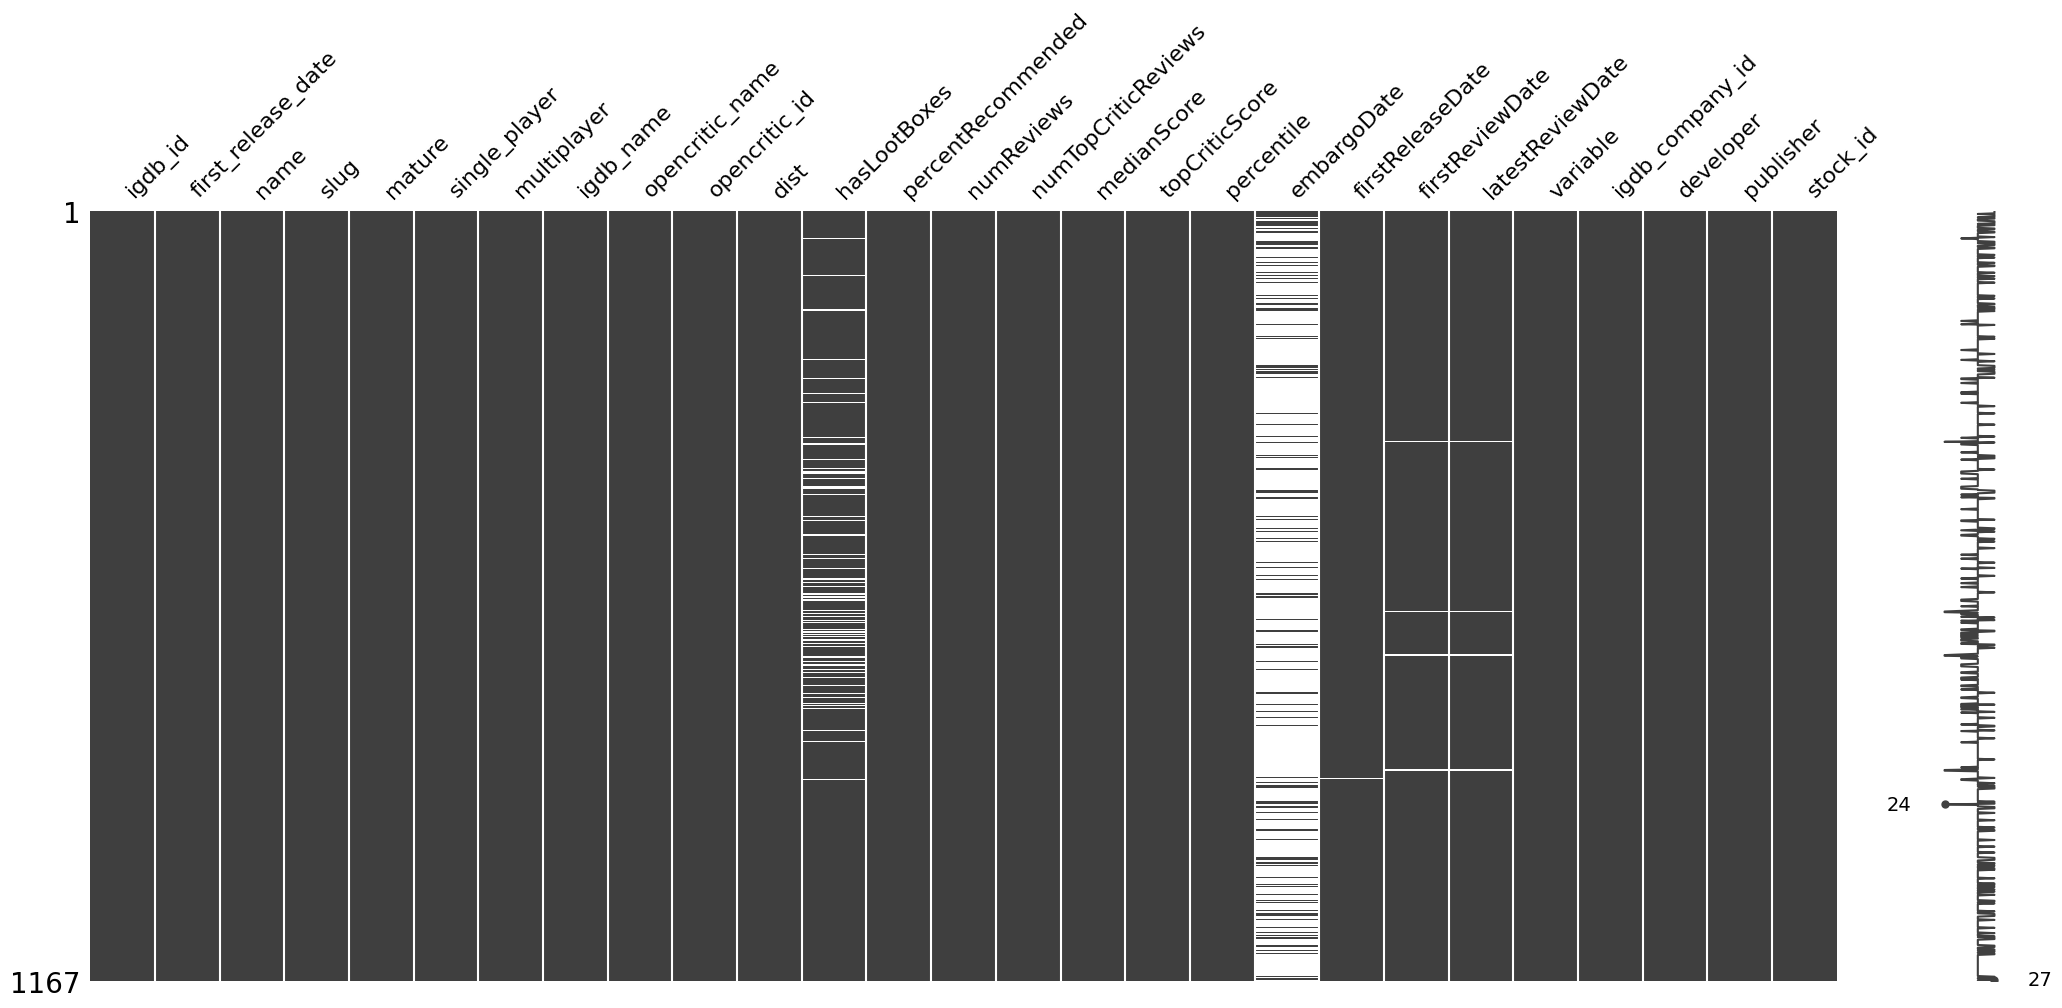

In [464]:
# Plot missing data.
%matplotlib inline

msno.matrix(games_reviews_long_df)

Need to check for negative values in the numeric fields.

In [465]:
games_reviews_long_df['medianScore'][games_reviews_long_df['medianScore'] < 0]

422    -1.0
626    -1.0
706    -1.0
774    -1.0
818    -1.0
       ... 
3850   -1.0
3852   -1.0
3854   -1.0
3898   -1.0
3918   -1.0
Name: medianScore, Length: 147, dtype: float64

Here it can be seen that `percentRecommended`, `topCriticScore`, `percentile` and `medianScore` have negative values. These columns will need to be dropped.

In [466]:
# Drop rows where percentRecommended values are negative.
games_reviews_long_df['percentRecommended'] = games_reviews_long_df['percentRecommended'].drop(
    games_reviews_long_df[games_reviews_long_df['percentRecommended'] < 0].index)
games_reviews_long_df[games_reviews_long_df['percentRecommended'] < 0].head()

,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,opencritic_id,...,percentile,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id


In [467]:
# Drop rows where topCriticScore values are negative.
games_reviews_long_df['topCriticScore'] = games_reviews_long_df['topCriticScore'].drop(
    games_reviews_long_df[games_reviews_long_df['topCriticScore'] < 0].index)
games_reviews_long_df[games_reviews_long_df['topCriticScore'] < 0].head()

,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,opencritic_id,...,percentile,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id


In [468]:
# Drop rows where percentile values are negative.
games_reviews_long_df['percentile'] = games_reviews_long_df['percentile'].drop(
    games_reviews_long_df[games_reviews_long_df['percentile'] < 0].index)
games_reviews_long_df[games_reviews_long_df['percentile'] < 0].head()

,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,opencritic_id,...,percentile,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id


In [469]:
# Drop rows where medianScore values are negative.
games_reviews_long_df['medianScore'] = games_reviews_long_df['medianScore'].drop(
    games_reviews_long_df[games_reviews_long_df['medianScore'] < 0].index)
games_reviews_long_df[games_reviews_long_df['medianScore'] < 0].head()

,igdb_id,first_release_date,name,slug,mature,single_player,multiplayer,igdb_name,opencritic_name,opencritic_id,...,percentile,embargoDate,firstReleaseDate,firstReviewDate,latestReviewDate,variable,igdb_company_id,developer,publisher,stock_id


Need to investigate the distance of the reviews as they are based on an inverse trigram distance search and some of the results are likely to be incorrect. The descriptive statistics show that over 75% of the observations are zero. Further investigation is required for the higher percentiles.

In [470]:
# Investigate 90th percentile.
games_reviews_long_df['dist'].quantile(0.9)

0.3710526000000006

In [471]:
games_reviews_long_df.columns

Index(['igdb_id', 'first_release_date', 'name', 'slug', 'mature',
       'single_player', 'multiplayer', 'igdb_name', 'opencritic_name',
       'opencritic_id', 'dist', 'hasLootBoxes', 'percentRecommended',
       'numReviews', 'numTopCriticReviews', 'medianScore', 'topCriticScore',
       'percentile', 'embargoDate', 'firstReleaseDate', 'firstReviewDate',
       'latestReviewDate', 'variable', 'igdb_company_id', 'developer',
       'publisher', 'stock_id'],
      dtype='object')

In [472]:
# Get games with a distance more than 0.
games_reviews_long_df = games_reviews_long_df.sort_values(by=['dist'])
games_reviews_long_df[['igdb_id', 'name', 'opencritic_name', 'dist', 'numReviews', 'medianScore']][games_reviews_long_df['dist'] != 0].head()


,igdb_id,name,opencritic_name,dist,numReviews,medianScore
1970,103335,Nelke & the Legendary Alchemists: Ateliers of ...,Nelke & The Legendary Alchemists: Ateliers of ...,0.019608,37.0,70.0
958,28125,Layton's Mystery Journey: Katrielle and the Mi...,Layton's Mystery Journey: Katrielle and the Mi...,0.044776,42.0,70.0
2774,127205,The Secret Order 8: Return to the Buried Kingdom,The Secret Order: Return to the Buried Kingdom,0.047619,1.0,NaN
3614,172822,Atelier Sophie 2: The Alchemist of the Mysteri...,Atelier Sophie 2: The Alchemist & The Mysterio...,0.060000,68.0,80.0
206,11253,Rigs: Mechanized Combat League,Rigs: Mechanized Combat League (VR),0.090909,33.0,80.0


159 games have a distance less than zero and there are clearly some mismatches here. As an initial sanity check, ensure that the IGDB release data and the OpenCritic release date match. This should reduce the number of exceptions.

In [473]:
pd.options.mode.chained_assignment = None  # default='warn'
games_reviews_long_df['dist'].loc[214] = 0
games_reviews_long_df['dist'].loc[1970] = 0
games_reviews_long_df['dist'].loc[958] = 0
games_reviews_long_df['dist'].loc[2774] = 0
games_reviews_long_df['dist'].loc[3614] = 0
games_reviews_long_df['dist'].loc[206] = 0
games_reviews_long_df['dist'].loc[1354] = 0
games_reviews_long_df['dist'].loc[322] = 0
games_reviews_long_df['dist'].loc[522] = 0
games_reviews_long_df['dist'].loc[754] = 0
games_reviews_long_df['dist'].loc[3730] = 0
games_reviews_long_df['dist'].loc[1418] = 0
games_reviews_long_df['dist'].loc[3482] = 0
games_reviews_long_df['dist'].loc[2038] = 0
games_reviews_long_df['dist'].loc[3726] = 0
games_reviews_long_df['dist'].loc[3532] = 0
games_reviews_long_df['dist'].loc[2314] = 0
games_reviews_long_df['dist'].loc[1290] = 0
games_reviews_long_df['dist'].loc[1476] = 0
games_reviews_long_df['dist'].loc[3022] = 0
games_reviews_long_df['dist'].loc[2290] = 0
games_reviews_long_df['dist'].loc[3726] = 0
games_reviews_long_df['dist'].loc[2682] = 0
games_reviews_long_df['dist'].loc[3282] = 0
pd.options.mode.chained_assignment = 'warn'

In [474]:
games_reviews_long_df.shape

(1167, 27)

In [475]:
games_reviews_long_df = games_reviews_long_df[games_reviews_long_df['dist'] < 0.01]

In [476]:
games_reviews_long_df[['igdb_id', 'name', 'opencritic_name', 'dist', 'numReviews', 'medianScore']].head()

,igdb_id,name,opencritic_name,dist,numReviews,medianScore
2,117,The Last Guardian,The Last Guardian,0.0,128.0,85.0
2506,119386,Empire of Sin,Empire of Sin,0.0,60.0,62.5
2508,119422,eFootball PES 2020,eFootball PES 2020,0.0,71.0,82.0
2510,119422,eFootball PES 2020,eFootball PES 2020,0.0,71.0,82.0
2514,120175,One Punch Man: A Hero Nobody Knows,One-Punch Man: A Hero Nobody Knows,0.0,76.0,60.0


In [477]:
games_reviews_long_df.shape

(1031, 27)

Create a new date column called `date` which takes the value of `embargoDate` where available and release_date otherwise.

In [478]:
# Parse first release date as datetime.
games_reviews_long_df['first_release_date'] = pd.to_datetime(games_reviews_long_df['first_release_date'],unit='s')

In [479]:
# Function for converting from ISO to date.
def from_iso_to_date(iso_string):
    # Handle nan values
    if iso_string == iso_string:
        dt = datetime.strptime(str(iso_string), "%Y-%m-%dT%H:%M:%S.%fZ")
        formatted_date = dt.strftime("%Y-%m-%d")
        return formatted_date
    # Return nan if datetime is nan.
    else:
        return np.nan

In [480]:
games_reviews_long_df['embargoDate'] = games_reviews_long_df['embargoDate'].map(from_iso_to_date)
games_reviews_long_df['embargoDate'] = pd.to_datetime(games_reviews_long_df['embargoDate'], format='%Y-%m-%d')

In [481]:
games_reviews_long_df.dtypes

igdb_id                         int64
first_release_date     datetime64[ns]
name                           object
slug                           object
mature                           bool
single_player                    bool
multiplayer                      bool
igdb_name                      object
opencritic_name                object
opencritic_id                   int64
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
embargoDate            datetime64[ns]
firstReleaseDate               object
firstReviewDate                object
latestReviewDate               object
variable                       object
igdb_company_id                 int64
developer                        bool
publisher                        bool
stock_id    

In [482]:
# Function which returns embargo date if it exists and release date otherwise.
def embargo_date_or_release_date(embargo_date, release_date):
    if embargo_date == embargo_date:
        return embargo_date
    else:
        return release_date

In [483]:
games_reviews_long_df['date'] = games_reviews_long_df.apply(lambda x: embargo_date_or_release_date(embargo_date=x['embargoDate'], release_date=x['first_release_date']), axis=1)


In [484]:
# Now free to drop embargo date column.
games_reviews_long_df = games_reviews_long_df.drop(columns=['embargoDate'])

In [485]:
games_reviews_long_df.dtypes

igdb_id                         int64
first_release_date     datetime64[ns]
name                           object
slug                           object
mature                           bool
single_player                    bool
multiplayer                      bool
igdb_name                      object
opencritic_name                object
opencritic_id                   int64
dist                          float64
hasLootBoxes                   object
percentRecommended            float64
numReviews                    float64
numTopCriticReviews           float64
medianScore                   float64
topCriticScore                float64
percentile                    float64
firstReleaseDate               object
firstReviewDate                object
latestReviewDate               object
variable                       object
igdb_company_id                 int64
developer                        bool
publisher                        bool
stock_id                       object
date        

In [486]:
# Export results as csv.
games_reviews_long_df.to_csv('games_reviews_flat.csv')